## For Colab only

In [1]:
!git clone https://github.com/maftukh/news_classifier.git

Cloning into 'news_classifier'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 32 (delta 10), reused 17 (delta 6), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [2]:
!ls news_classifier/

bert_classification_model.ipynb		      data     evals.py  optim.py
bert_classification_model_with_modules.ipynb  data.py  model.py  README.md


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Fix the path to get the correct model
!mkdir ./news_classifier/model/
!cp /content/gdrive/MyDrive/data/news_cat/model/finetuned_pytorch_model_32_ep5.bin ./news_classifier/model/

## Imports

In [5]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 39.7 MB/s 
     |████████████████████████████████| 8.7 MB 39.5 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 138 kB 53.3 MB/s 
     |████████████████████████████████| 127 kB 51.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import os
import sys
import random
from pathlib import Path

# Third-party packages
import numpy as np
import pandas as pd
from pytorch_pretrained_bert.tokenization import BertTokenizer
import torch
from tqdm.notebook import tqdm, trange

sys.path.append('/content/news_classifier')

# Custom imports
import model
import data
import evals
import optim



In [7]:
# To make sure custom modules are up-to-date by the time of each call
%load_ext autoreload
%autoreload 2

## Model Parameters

In [8]:
DATA_PATH = Path('news_classifier/data/')
MODEL_PATH = Path('news_classifier/model/')

args = {
    "data_dir": DATA_PATH,
    "output_dir": MODEL_PATH,
    "ckpt_name": 'pretrain.ckpt', # Файл с которого хочется продолжить обучение
    
    "task_name": "news_cat_label",
    "bert_model": 'bert-base-uncased',  # оптимальная моделька с точки зрения веса, вряд ли стоит менять
    "do_lower_case": True,
    
    "max_seq_length": 32, # Сколько слов из колонки 'text' используется в модели
    "batch_size": 128, # размер батча на входе в модель
    'eval_steps': 500, # Через сколько шагов делать промежуточную оценку модели
    
    "learning_rate": 3e-5,
    "num_train_epochs": 5.0,
    "warmup_proportion": 0., # При .1 - первые 10% шагов обучения будут плавными, чтоб избежать взрыва градиентов 

    "no_cuda": False, # Если есть cuda, но почему-то не хочешь юзать
    "seed": 42,
}



In [9]:
def set_random_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [10]:
# Setup GPU parameters
args['device'] = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")

set_random_seeds(args['seed'])

In [11]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
args['logger'] = logging.getLogger(__name__)

## Preprocess data

### Read Train Dataset

In [12]:
### How to get cleaned.csv - but it's already pre-computed

# df_orig = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)
# df_orig['text'] = df_orig['headline'] + ' ' + df_orig['short_description']

# df_orig[['category', 'text']].to_csv('data/cleaned.csv')
# df_orig.head()

In [13]:
def custom_filter_dataset(df):
    df = df.copy()
    col_map = {
        'STYLE & BEAUTY': 'STYLE',
        'CULTURE & ARTS': 'ARTS',
        'ARTS & CULTURE': 'ARTS',
        'WORLDPOST': 'WORLD NEWS',
        'WELLNESS': 'HEALTHY LIVING',
        'COMEDY': 'ENTERTAINMENT',
        'GREEN': 'ENVIRONMENT',
        'TASTE': 'FOOD & DRINK'
    }

    white_list = [
        'POLITICS',
        'HEALTHY LIVING',
        'ENTERTAINMENT',
        'TRAVEL',
        'FOOD & DRINK',
        'BUSINESS',
        'SPORTS',
        'HOME & LIVING',
        'WORLD NEWS',
        'WOMEN',
        'SCIENCE',
        'STYLE',
        'ARTS',
        'TECH',
        'MONEY',
        'ENVIRONMENT',
        'RELIGION']

    df['category'] = df['category'].map(lambda x: col_map[x] if x in col_map else x)
    df['category'] = df['category'].map(lambda x: x if x in white_list else 'OTHER')

    # Too much of OTHER, which could lead to some bias towards it - let's sample
    drop_list = df.query('category == "OTHER"').sample(frac=.75).index
    df = df.drop(drop_list)

    # Also filter news with too few words
    df = df[df['text'].str.split().str.len() >= 5]

    return df

In [14]:
df = pd.read_csv(os.path.join(args['data_dir'], 'cleaned.csv'), index_col=0)
assert 'text' in df.columns, "dataframe must contain 'text' column"
assert 'category' in df.columns, "dataframe must contain 'category' column"
df = custom_filter_dataset(df)
df.shape

(160520, 2)

In [15]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 18
category
ARTS               3846
BUSINESS           5897
ENTERTAINMENT     21020
ENVIRONMENT        3926
FOOD & DRINK       8298
HEALTHY LIVING    24385
HOME & LIVING      4193
MONEY              1707
OTHER             13118
POLITICS          32622
RELIGION           2501
SCIENCE            2170
SPORTS             4845
STYLE             11889
TECH               2080
TRAVEL             9853
WOMEN              3467
WORLD NEWS         4703
dtype: int64


### Split data

In [16]:
train, val, test = data.get_data_splits(df, train_size=0.7, test_size=0.15, random_seed=200)
print(train.shape, val.shape, test.shape)
train.to_csv(os.path.join(args['data_dir'], 'train.csv'), encoding='utf-8')
val.to_csv(os.path.join(args['data_dir'], 'val.csv'), encoding='utf-8')
test.to_csv(os.path.join(args['data_dir'], 'test.csv'), encoding='utf-8')

(112364, 20) (24078, 20) (24078, 20)


## Data preparations

In [17]:
# args['label_list'] = np.sort(df.category.unique()) - в будущем для обучения лучше так. У меня просто модель со след списком обучилась:
args['label_list'] = ['ENTERTAINMENT', 'WORLD NEWS', 'OTHER', 'POLITICS', 'WOMEN', 'SPORTS',
       'BUSINESS', 'TRAVEL', 'TECH', 'RELIGION', 'SCIENCE', 'ARTS', 'STYLE',
       'ENVIRONMENT', 'FOOD & DRINK', 'HEALTHY LIVING', 'HOME & LIVING',
       'MONEY']
args['num_labels'] = len(args['label_list'])
args['num_labels'], args['label_list']    

(18,
 ['ENTERTAINMENT',
  'WORLD NEWS',
  'OTHER',
  'POLITICS',
  'WOMEN',
  'SPORTS',
  'BUSINESS',
  'TRAVEL',
  'TECH',
  'RELIGION',
  'SCIENCE',
  'ARTS',
  'STYLE',
  'ENVIRONMENT',
  'FOOD & DRINK',
  'HEALTHY LIVING',
  'HOME & LIVING',
  'MONEY'])

In [18]:
processor = data.LabelTextProcessor(args['data_dir'], labels=args['label_list'])
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

04/08/2022 11:55:38 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpdlrnuxpd
100%|██████████| 231508/231508 [00:00<00:00, 3360762.17B/s]
04/08/2022 11:55:38 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpdlrnuxpd to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
04/08/2022 11:55:38 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
04/08/2022 11:55:38 - INFO - pytorch_pretrained_bert.file_utils -   removing temp file /tmp/tmpdlrnuxpd
04/08/2022 11:55:38 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws

In [19]:
train_examples = processor.get_train_examples(args['data_dir'])
train_features = data.convert_examples_to_features(train_examples, args['label_list'], args['max_seq_length'], tokenizer)

val_examples = processor.get_dev_examples(args['data_dir'])
val_features = data.convert_examples_to_features(val_examples, args['label_list'], args['max_seq_length'], tokenizer)

test_examples = processor.get_test_examples(args['data_dir'])
test_features = data.convert_examples_to_features(test_examples, args['label_list'], args['max_seq_length'], tokenizer)

In [20]:
args['num_train_steps'] = int(len(train_examples) / args['batch_size'] * args['num_train_epochs'])

## Prepare model

In [ ]:
if args['ckpt_name'] in os.listdir(args['output_dir']):
    bert_model = model.get_model(model_path=Path(args['output_dir'], args['ckpt_name']), 
                                  bert_model=args['bert_model'], 
                                  num_labels=args['num_labels'])
else:
    bert_model = model.get_model(bert_model=args['bert_model'], 
                                  num_labels=args['num_labels'])

bert_model.to(args['device'])

## Train model

### Load training data

In [23]:
train_dataloader = data.prepare_dataloader(train_features, args['batch_size'])
val_dataloader = data.prepare_dataloader(val_features, args['batch_size'], test=True)
test_dataloader = data.prepare_dataloader(test_features, args['batch_size'], test=True)

### Train Model

In [ ]:
evals.fit(bert_model, train_dataloader, val_dataloader, args)

In [ ]:
# It's possible to freeze/unfreeze BERT layers for finetuning 
#bert_model.freeze_bert_encoder()
#bert_model.unfreeze_bert_encoder()

### Save model

In [ ]:
fname = "finetuned_pytorch_model.bin"
output_model_file = os.path.join(args['output_dir'], fname)
torch.save(bert_model.state_dict(), output_model_file)

### Load model

In [ ]:
# fname = "finetuned_pytorch_model.bin"
# output_model_file = os.path.join(args['output_dir'], fname)

fname = "finetuned_pytorch_model_32_ep5.bin"
output_model_file = os.path.join('/content/gdrive/MyDrive/data/news_cat/model', fname)

bert_model = model.get_model(model_path=output_model_file, 
                             bert_model=args['bert_model'], 
                             num_labels=args['num_labels'])
bert_model.to(args['device'])

### Model Evaluation on Test data

In [26]:
evals.evaluate(bert_model, test_dataloader, args)

  0%|          | 0/189 [00:00<?, ?it/s]

04/08/2022 12:02:52 - INFO - __main__ -   ***** Eval results *****
04/08/2022 12:02:52 - INFO - __main__ -     eval_accuracy = 0.8791427859456765
04/08/2022 12:02:52 - INFO - __main__ -     eval_loss = 0.48573130511102225


{'eval_accuracy': 0.8791427859456765, 'eval_loss': 0.48573130511102225}

In [31]:
result, raw_logits, embeddings = evals.predict(bert_model, 'test.csv', processor, tokenizer, args)

Prediction Iteration:   0%|          | 0/189 [00:00<?, ?it/s]

In [32]:
test_cats = test.category
result.index = test_cats.index

In [33]:
result.columns[result.values.argmax(axis=1)]

Index(['WOMEN', 'WORLD NEWS', 'ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS',
       'BUSINESS', 'WOMEN', 'ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS',
       ...
       'ENTERTAINMENT', 'MONEY', 'HEALTHY LIVING', 'STYLE', 'STYLE',
       'ENTERTAINMENT', 'ENTERTAINMENT', 'TECH', 'SPORTS', 'SPORTS'],
      dtype='object', length=24078)

Text(0.5, 1.0, 'Confusion matrix of model')

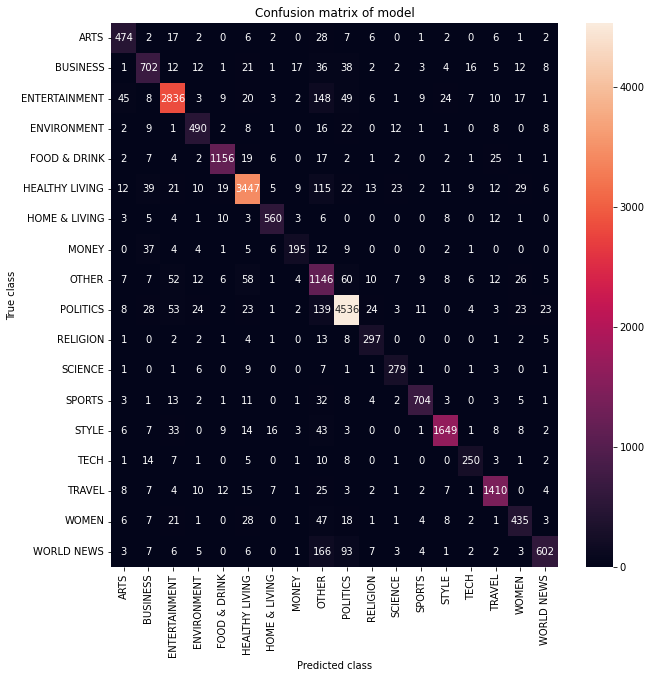

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 


cf_matrix = confusion_matrix(result.columns[result.values.argmax(axis=1)], test_cats)


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, 
                      xticklabels=sorted(result.columns),
                      yticklabels=sorted(result.columns),
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')